In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('car_fuel_efficiency.csv')
data.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [3]:
data.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

# Preprocess

* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the train_test_split function and set the random_state parameter to 1.
* Use DictVectorizer(sparse=True) to turn the dataframes into matrices.


In [4]:
data = data.fillna(0)
data.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(5822, 1941, 1941)

In [6]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

# Q1: Train a decision tree regressor

Train with max_depth = 1

Which feature is used to split the data?

In [8]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [9]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



# Q2: Training a random forest regressor

* n_estimators=10
* random_state = 1
* n_jobs=-1

What is the RMSE of the model on val data?

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
from sklearn.metrics import root_mean_squared_error

y_pred = rf.predict(X_val)

root_mean_squared_error(y_pred, y_val)

0.45997775573361477

# Q3: Experiment with n_estimators params

* Try values from 10 to 200 with step 10
* random_state = 1
* Evaluate model on the val set

After which values of n_estimators does rmse stop improving?

In [15]:
scores = []

for n in np.arange(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)

    score = root_mean_squared_error(y_pred, y_val)
    scores.append(round(score, 3))



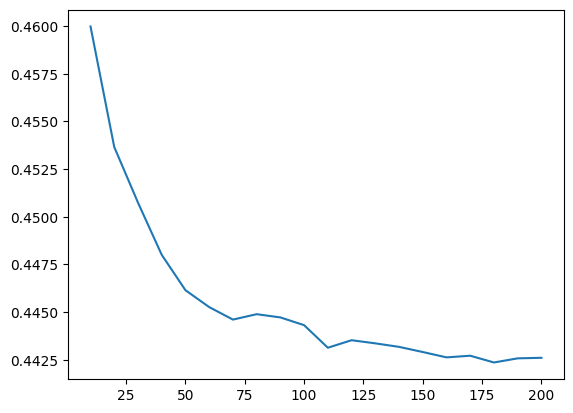

In [13]:
plt.plot(np.arange(10, 201, 10), scores)

# Q4: Lets select max_depth

* Try different depth [10, 15, 20, 25]
* For each value, 
    try different estimator from 10 to 200 with step 10
    calc mean rmse
* Fix random_state = 1

Whats the max_depth using mean RMSE?

In [20]:
scores = []

for d in [10, 15, 20, 25]:
    depth_scores = []
    for n in np.arange(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, 
                                   max_depth=d,
                                   random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)

        score = root_mean_squared_error(y_pred, y_val)
        depth_scores.append(round(score, 3))
    scores.append(sum(depth_scores)/len(depth_scores))


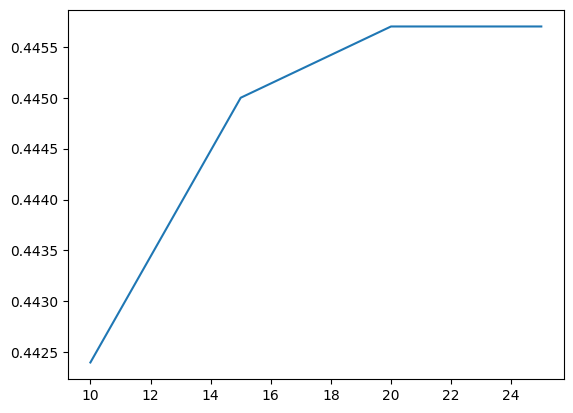

In [21]:
plt.plot([10, 15, 20, 25], scores)

In [22]:
scores

[0.4424, 0.44499999999999995, 0.4456999999999999, 0.4456999999999998]

# Q5 Feature Importance

* Train the model with these parameters:
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1 (optional)
* Get the feature importance information from this model

Whats the most important feature?

In [33]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

list(zip(dv.get_feature_names_out(), rf.feature_importances_))
    

[('acceleration', np.float64(0.011470716492980844)),
 ('drivetrain=All-wheel drive', np.float64(0.0003818097503064222)),
 ('drivetrain=Front-wheel drive', np.float64(0.0003118420847931986)),
 ('engine_displacement', np.float64(0.003269323417164303)),
 ('fuel_type=Diesel', np.float64(0.00034369341131184716)),
 ('fuel_type=Gasoline', np.float64(0.00033667198836755764)),
 ('horsepower', np.float64(0.016040214819390403)),
 ('model_year', np.float64(0.0031822984145892436)),
 ('num_cylinders', np.float64(0.0023586709360923362)),
 ('num_doors', np.float64(0.001591133064507162)),
 ('origin=Asia', np.float64(0.00047610304607445227)),
 ('origin=Europe', np.float64(0.0005203580827405653)),
 ('origin=USA', np.float64(0.0005551519590830011)),
 ('vehicle_weight', np.float64(0.9591620125325987))]

# Q6: Train an XGBoost 

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [34]:
import xgboost as xgb

features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [35]:
xgb_params={
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:1.81393	val-rmse:1.85444
[5]	train-rmse:0.51381	val-rmse:0.55664
[10]	train-rmse:0.37115	val-rmse:0.43896
[15]	train-rmse:0.34666	val-rmse:0.43362
[20]	train-rmse:0.33553	val-rmse:0.43376
[25]	train-rmse:0.32268	val-rmse:0.43683
[30]	train-rmse:0.31475	val-rmse:0.43752
[35]	train-rmse:0.30960	val-rmse:0.43784
[40]	train-rmse:0.30202	val-rmse:0.43968
[45]	train-rmse:0.29126	val-rmse:0.44024
[50]	train-rmse:0.28456	val-rmse:0.44140
[55]	train-rmse:0.27618	val-rmse:0.44225
[60]	train-rmse:0.26768	val-rmse:0.44290
[65]	train-rmse:0.26174	val-rmse:0.44352
[70]	train-rmse:0.25489	val-rmse:0.44531
[75]	train-rmse:0.24792	val-rmse:0.44628
[80]	train-rmse:0.24254	val-rmse:0.44689
[85]	train-rmse:0.23644	val-rmse:0.44749
[90]	train-rmse:0.23193	val-rmse:0.44839
[95]	train-rmse:0.22475	val-rmse:0.44904
[99]	train-rmse:0.21950	val-rmse:0.45018


In [36]:
y_pred = model.predict(dval)
root_mean_squared_error(y_pred, y_val)

0.45017755678087246

In [37]:
xgb_params={
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:2.28944	val-rmse:2.34561
[5]	train-rmse:1.41247	val-rmse:1.44988
[10]	train-rmse:0.91008	val-rmse:0.94062
[15]	train-rmse:0.63402	val-rmse:0.66672
[20]	train-rmse:0.48983	val-rmse:0.53064
[25]	train-rmse:0.41881	val-rmse:0.46891
[30]	train-rmse:0.38342	val-rmse:0.44289
[35]	train-rmse:0.36435	val-rmse:0.43250
[40]	train-rmse:0.35343	val-rmse:0.42746
[45]	train-rmse:0.34621	val-rmse:0.42595
[50]	train-rmse:0.33998	val-rmse:0.42498
[55]	train-rmse:0.33480	val-rmse:0.42449
[60]	train-rmse:0.33054	val-rmse:0.42456
[65]	train-rmse:0.32602	val-rmse:0.42493
[70]	train-rmse:0.32202	val-rmse:0.42503
[75]	train-rmse:0.31895	val-rmse:0.42526
[80]	train-rmse:0.31667	val-rmse:0.42563
[85]	train-rmse:0.31440	val-rmse:0.42574
[90]	train-rmse:0.31059	val-rmse:0.42586
[95]	train-rmse:0.30625	val-rmse:0.42611
[99]	train-rmse:0.30419	val-rmse:0.42623


In [38]:
y_pred = model.predict(dval)
root_mean_squared_error(y_pred, y_val)

0.42622800553359225